In [1]:
import numpy as np
from datetime import datetime
# from module_.readText import read_hh
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
# load dataset
directory_hh101="./dataset/hh/hh101/ann.txt"

f=open(directory_hh101, 'r')
txt=f.readlines()
events=[]
activity = "Idle"
for i, line in enumerate(txt):
    event = []
    
    try:
        f_info = line.split()
        # Date, time, sensor, value, (label)

        event.append(f_info[2])
        event.append(f_info[3])
        if not ('.' in str(np.array(f_info[0])) + f_info[1]):
            f_info[1] = f_info[1] + '.000000'
        timestamp=datetime.timestamp(datetime.strptime(f_info[0] + f_info[1], "%Y-%m-%d%H:%M:%S.%f"))
        event.append(float(timestamp))           # 3. timestamp

        if len(f_info) != 4: # label
            label = str(' '.join(np.array(f_info[4:])))
            if 'begin' in label:
                activity = label.split('=')[0].strip()
                event.append(activity)
            elif 'end' in label:
                event.append(activity)
                activity = "Idle"
            else:
                event.append(activity)
        else:
            event.append(activity)
        
        events.append(event)

    except:
        print("SKIP")

raw_length = len(events)

print(Counter(np.array(events)[:,3]))

Counter({'Idle': 105797, 'Watch_TV': 64010, 'Sleep_Out_Of_Bed': 18527, 'Bathe': 16995, 'Cook_Breakfast': 16130, 'Sleep': 13006, 'Personal_Hygiene': 12877, 'Toilet': 12800, 'Dress': 9018, 'Relax': 8138, 'Cook_Dinner': 5437, 'Read': 4600, 'Wash_Breakfast_Dishes': 4033, 'Wash_Dishes': 3849, 'Eat_Breakfast': 3415, 'Leave_Home': 3155, 'Morning_Meds': 3057, 'Cook_Lunch': 3041, 'Enter_Home': 2917, 'Entertain_Guests': 2569, 'Evening_Meds': 2442, 'Wash_Dinner_Dishes': 2408, 'Cook': 1875, 'Eat_Dinner': 1112, 'Groom': 970, 'Wash_Lunch_Dishes': 933, 'Phone': 896, 'Eat_Lunch': 790, 'Bed_Toilet_Transition': 674, 'Eat': 424, 'Work_At_Table': 169})


In [3]:
events = [e for e in events if e[0][0] in list('MD')]

startindices = [i for i in range(1, len(events)) if events[i][3]!=events[i-1][3]]
startindices = [0]+startindices+[len(events)]

dict_consecutiveActivities = {
    'chunks':[],
    'labels':[],
    'lengths':[],
}

chunksize = 8

CoC=[]
CoLbl=[]
CoLen=[]
for i in range(len(startindices)-1):
    start, end_ = startindices[i:i+2]
    chunk=events[start:end_]

    labelset = list(set(np.array(chunk)[:,3]))
    assert len(labelset)==1
    label = labelset[0]

    if len(CoC)==chunksize:
        dict_consecutiveActivities['chunks'].append(CoC)
        dict_consecutiveActivities['labels'].append(CoLbl)
        dict_consecutiveActivities['lengths'].append(CoLen)
        # CoC = CoLbl = CoLen = []
        CoC, CoLbl, CoLen = [], [], []

    CoC.append(chunk)
    CoLbl.append(label)
    CoLen.append(len(chunk))

"""ChunksByActivity"""
# dict_activity = {}

# for i in range(len(startindices)-1):
#     start, end_ = startindices[i:i+2]
#     chunks=events[start:end_]

#     labelset = list(set(np.array(chunks)[:,3]))
#     assert len(labelset)==1
#     label = labelset[0]

#     if label not in dict_activity.keys():
#         dict_activity[label]=[np.array(chunks)]
#     else:
#         dict_activity[label].append(np.array(chunks))

'ChunksByActivity'

In [4]:
"""Test: Second Chunks"""
ti = 3
test_chunk = np.concatenate(dict_consecutiveActivities['chunks'][ti])
test_label = dict_consecutiveActivities['labels'][ti]
test_length = dict_consecutiveActivities['lengths'][ti]

print(test_chunk.shape, test_label, test_length)

transitions = []
start=0
for i in range(len(test_length)-1):
    transitions.append(start+test_length[i])
    start+=test_length[i]

# test_time = [float(timestamp) for timestamp in test_chunk[:,2]]
# start_time = min(test_time)
# test_time = np.array(test_time)-start_time


(417, 4) ['Idle', 'Personal_Hygiene', 'Idle', 'Toilet', 'Idle', 'Watch_TV', 'Idle', 'Leave_Home'] [66, 180, 80, 14, 16, 20, 37, 4]


In [5]:

window_size = 30
view_size = 5

# Sliding window
# windows=[]
# for i in range(len(test_chunk)):
#     window = []
#     earliest = i-window_size+1
#     while earliest<=i:
#         idx = max(0, earliest)
#         window.append(test_chunk[idx])
#         earliest+=1

#     assert len(window)==window_size
#     assert sum(window[-1]==test_chunk[i])==len(test_chunk[i])

#     windows.append(window)
# windows=np.array(windows)

D002 0
M001 1
M005 2
M006 3
M008 4
M009 5
M010 6
M011 7
M012 8
MA013 9
MA014 10
MA015 11
417
417


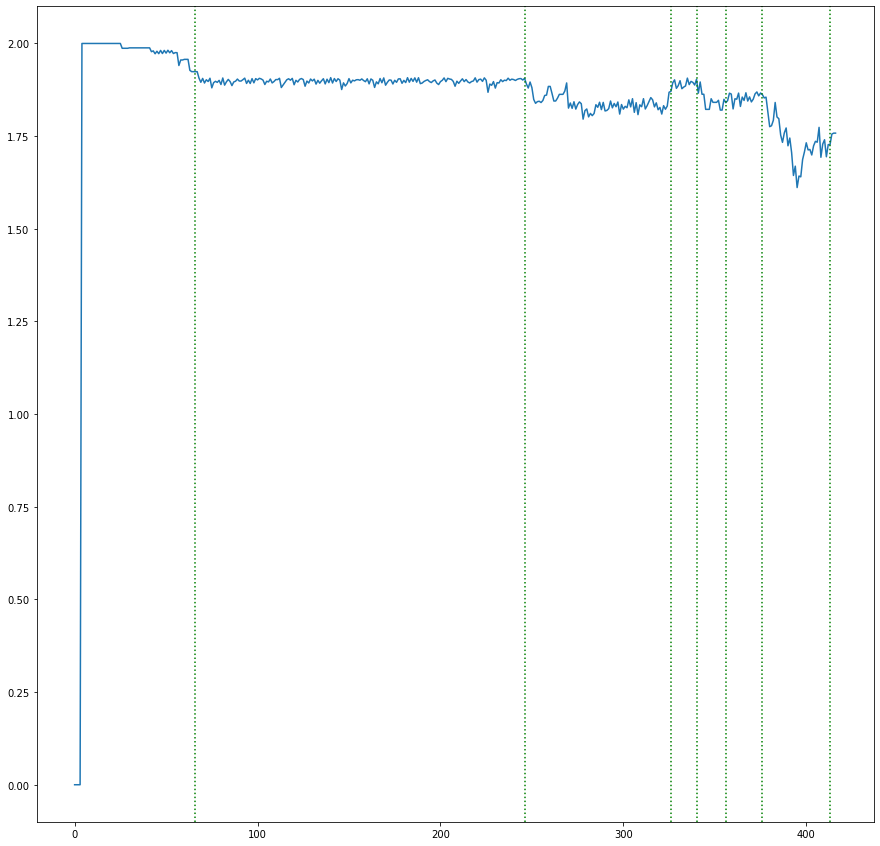

In [10]:
sensor_list = sorted(set(test_chunk[:,0]))

for sensor in sensor_list:
    print(sensor, sensor_list.index(sensor))

# correlation_matrix = np.diag(np.ones(len(sensor_list)))
correlation_matrix = np.ones((len(sensor_list), len(sensor_list)))
prev_matrix = correlation_matrix
dict_timestamps={}
l = []
r, c = (6, 3)
for i, event in enumerate(test_chunk):
    sensor = event[0]
    timestamp = float(event[2])

    if sensor not in dict_timestamps.keys():
        dict_timestamps[sensor]=[timestamp]
    else:
        dict_timestamps[sensor].append(timestamp)
    index_r = sensor_list.index(sensor)

    sensor_x = dict_timestamps[sensor][-view_size:]
    if len(sensor_x)<view_size:
        l.append(0 if len(l)==0 else l[-1])
        continue

    for sensor_ in dict_timestamps.keys():
        if sensor_==sensor:
            continue
        sensor_y = dict_timestamps[sensor_][-view_size:]
        if len(sensor_y)<view_size:
            continue
        index_c = sensor_list.index(sensor_)
        # col.append(np.corrcoef(sensor_x, sensor_y)[0,1])
        correlation_matrix[index_r, index_c]=np.corrcoef(sensor_x, sensor_y)[0,1]
        correlation_matrix[index_c, index_r]=np.corrcoef(sensor_x, sensor_y)[0,1]
    l.append(np.average(correlation_matrix+prev_matrix))
    prev_matrix = correlation_matrix
    
print(len(test_chunk))
print(len(l))
    
# print(correlation_matrix)
# plt.title("{}".format(sensor_list[c]))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(len(l)), l)
for t in transitions:
    plt.axvline(x=t, linestyle=':', color='g')

In [ ]:
test_chunk